# gerekli kütüphaneler

In [1]:
# uyarı ayarı
import warnings
warnings.filterwarnings("ignore")

# veri işleme
import pandas as pd
import numpy as np

# istatistik
import scipy as sc
import hypothetical
import pingouin
import statsmodels as sm

# modelleme
import mlxtend
import lifetimes

# veri görselleştirme
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import HTML, display

# kütüphane ayarları
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('mode.chained_assignment', None)

sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})

# verinin çalışma ortamına alınması

2009-2011 dönemi verileri **veri** isimli değişken olarak çalışma ortamına alınır:

In [2]:
veri = pd.read_csv("dataset/online_retail_2.csv")

In [3]:
print(veri.shape)
veri.head()

(1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
veri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


# veri hazırlığı

In [5]:
# ülke grupları
avrupa_ülkeleri = ['Austria', 'Belgium', 'Cyprus', 'Czech Republic', 'Denmark',
                   'EIRE', 'European Community', 'Finland', 'France', 'Germany',
                   'Greece', 'Iceland','Italy', 'Lithuania', 'Malta', 'Netherlands',
                   'Norway', 'Poland', 'Portugal', 'Spain', 'Sweden', 'Switzerland',
                   'United Kingdom', 'Channel Islands']

amerika_ülkeleri = ['Canada', 'USA', 'Brazil', 'Bermuda']

asya_ülkeleri = ['Bahrain','Hong Kong', 'Japan', 'Saudi Arabia', 'Singapore', 'Thailand', 'United Arab Emirates']

# ülke grupları fonksiyon
def ülke_grubu(row):
    global avrupa_ülkeleri
    global amerika_ülkeleri
    global asya_ülkeleri
    
    if row['Country'] in avrupa_ülkeleri:
        return "Europe"
    elif row['Country'] in amerika_ülkeleri:
        return "America"
    elif row['Country'] in asya_ülkeleri:
        return "Asia"
    else:
        return "Other"


# veri önişleme fonksiyonu
def veri_önişleme(veri):
    
    # kayıp değerlerin atılması
    veri.dropna(axis = 0, subset = ['Description', 'Customer ID'], inplace = True)
    
    # çoklayan kayıtların atılması
    veri.drop_duplicates(inplace = True)
    
    # tip dönüşümleri
    veri['InvoiceDate']   = pd.to_datetime(veri['InvoiceDate'])
    veri['Customer ID']   = veri['Customer ID'].astype(np.int64)
    veri = veri[veri['Invoice'].str.startswith("C",na=False) == False]
    veri['Invoice'] = veri['Invoice'].astype(np.int64)
    
    # yeni değişkenlerin oluşturulması
    veri['TotalPrice'] = veri['Price']*veri['Quantity']
    veri = veri.assign(CountryGroup=veri.apply(ülke_grubu, axis=1))
    
    return veri

In [6]:
veri = veri_önişleme(veri)

In [7]:
veri.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,CountryGroup
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4,Europe
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,Europe
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,Europe
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8,Europe
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0,Europe


In [8]:
veri.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 779495 entries, 0 to 1067370
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Invoice       779495 non-null  int64         
 1   StockCode     779495 non-null  object        
 2   Description   779495 non-null  object        
 3   Quantity      779495 non-null  int64         
 4   InvoiceDate   779495 non-null  datetime64[ns]
 5   Price         779495 non-null  float64       
 6   Customer ID   779495 non-null  int64         
 7   Country       779495 non-null  object        
 8   TotalPrice    779495 non-null  float64       
 9   CountryGroup  779495 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 65.4+ MB


# müşteri yaşamboyu değeri (customer lifetime value-clv) modeli

model için terminoloji:

* Frekans(frequency), müşterinin yaptığı tekrarlanan satın alma işlemlerinin sayısını temsil eder. Bu, toplam alışveriş sayısından bir az olduğu anlamına gelir.
* T, seçilen zaman birimlerinde müşterinin yaşını temsil eder. Bu, bir müşterinin ilk satın alma işlemi ile çalışılan dönemin sonu arasındaki süreye eşittir.
* Yakınlık (recency), müşterinin en son alışverişini gerçekleştirdiği zamanki yaşını temsil eder. Bu, bir müşterinin ilk satın alma işlemi ile en son satın alma arasındaki süreye eşittir. (Dolayısıyla, yalnızca 1 alışveriş yapmışlarsa, yakınlık 0 olur.)

model çıktıları:

* $P(X(t) = x | λ, p)$ : t uzunluğundaki bir zaman diliminde x işlemi gözlemleme olasılığı
* $E(X(t) | λ, p)$ : t uzunluğundaki bir dönemde beklenen alışveriş sayısı
* $P(τ>t)$ : bir müşterinin τ periyodunda aktif olmama olasılığı

In [9]:
print(f"minimum alışveriş tarihi: {veri['InvoiceDate'].min()}")
print(f"minimum alışveriş tarihi: {veri['InvoiceDate'].max()}")

minimum alışveriş tarihi: 2009-12-01 07:45:00
minimum alışveriş tarihi: 2011-12-09 12:50:00


son 1 yıllık alışveriş verisi:

In [10]:
veri_son_yıl = veri[veri['InvoiceDate']>="2010-12-01"]
print(f"minimum alışveriş tarihi: {veri_son_yıl['InvoiceDate'].min()}")
print(f"minimum alışveriş tarihi: {veri_son_yıl['InvoiceDate'].max()}")

minimum alışveriş tarihi: 2010-12-01 08:26:00
minimum alışveriş tarihi: 2011-12-09 12:50:00


günlük zaman değişkeni:

In [11]:
veri_son_yıl['DailyDate'] = pd.to_datetime(veri_son_yıl['InvoiceDate']).dt.date

In [12]:
veri_son_yıl.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,CountryGroup,DailyDate
502938,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Europe,2010-12-01
502939,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Europe,2010-12-01
502940,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Europe,2010-12-01
502941,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Europe,2010-12-01
502942,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Europe,2010-12-01


In [13]:
ilgilendiğimiz_değişkenler = ["Customer ID", "DailyDate", "TotalPrice"]
myd_veri = veri_son_yıl[ilgilendiğimiz_değişkenler]

In [14]:
rfm_verisi = lifetimes.utils.summary_data_from_transaction_data(myd_veri, 
                                                                customer_id_col='Customer ID',
                                                                datetime_col='DailyDate',
                                                                monetary_value_col='TotalPrice'
                                                               )

RFM verisi:

In [15]:
print(f"tekil müşteri sayısı: {rfm_verisi.shape[0]}")
rfm_verisi.head()

tekil müşteri sayısı: 4339


,frequency,recency,T,monetary_value
Customer ID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000


**gözlemler:**

* analizimizde 4339 müşteri var.
* 12346 ID'li müşteri yalnızca 1 satın alma işlemi gerçekleştirmiş (tekrar yok), bu nedenle sıklığı ve yakınlığı 0 ve yaşı 325 gün (ör. İlk satın alma ile analizdeki sürenin sonu arasındaki süre).

müşteri frekansı özeti:
 count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64


frekansı 0 olan müşteri oranı: 0.3569946992394561


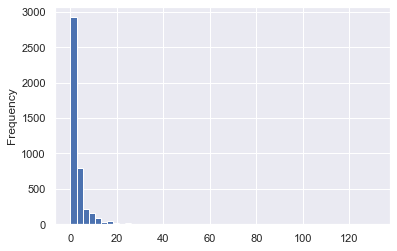

In [16]:
print(f"müşteri frekansı özeti:\n {rfm_verisi['frequency'].describe()}")
print("\n")
print(f"frekansı 0 olan müşteri oranı: {sum(rfm_verisi['frequency'] == 0)/float(len(rfm_verisi))}")
rfm_verisi['frequency'].plot(kind='hist', bins=50);

* verimizde tüm müşterilerin yaklaşık %35'inden fazlası yalnızca bir kez alışveriş yapmış.

* BG/NBD modeli:
* modelin ayrıntısı için: http://www.brucehardie.com/papers/bgnbd_2004-04-20.pdf
* modelin formel hali:

$$\begin{array}{l}
E\left(Y(t) \mid X=x, t_{x}, T, r, \alpha, a, b\right)= \\
\qquad \begin{array}{c}
\frac{a+b+x-1}{a-1}\left[1-\left(\frac{\alpha+T}{\alpha+T+t}\right)^{r+x}{2} F_{1}\left(r+x, b+x ; a+b+x-1 ; \frac{t}{\alpha+T+t}\right)\right] \\
1+\delta_{x>0} \frac{a}{b+x-1}\left(\frac{\alpha+T}{\alpha+t_{x}}\right)^{r+x}
\end{array}
\end{array}$$

In [17]:
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bgf_modeli = bgf.fit(rfm_verisi['frequency'], rfm_verisi['recency'], rfm_verisi['T'])

modelin özet çıktısı ve parametre tahminleri:

In [18]:
bgf_modeli.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


frekans/yakınlık matrisi:

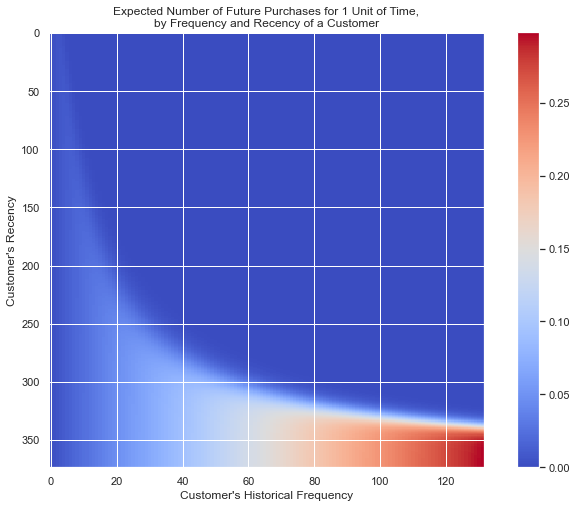

In [19]:
from lifetimes.plotting import plot_frequency_recency_matrix

fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf_modeli);

**gözlemler:**

* bir müşteri 120 alışveriş işlemi gerçekleştirdiyse ve en son alışverişi yaklaşık 350 günlükken gerçekleştiyse (ör. yakınlık: ilk alışverişi ile son alışverişi arasındaki süre 350 günse), o zaman en iyi müşterimizdir (sağ alttaki bölge).
* yakın zamand ve çok alışveriş yapan müşteriler muhtemelen gelecekte en iyi müşterilerimiz olacaktır. bu müşteriler en iyi müşterilerimizdir.
* çok alışveriş yapmış, ancak yakın zamanda (sağ üst köşe) alışveriş yapmamış müşteriler muhtemelen pasifleşmiştir.
* seyrek olarak satın alan müşteriyi temsil eden (40, 300) civarında başka bir müşteri türü de var ve onu son zamanlarda görmediğimiz için tekrar alışveriş yapma ihtimali de var. ancak, pasifleşmiş mi yoksa sadece alışveriş yapanlar arasında mı emin değiliz.

hangi müşterilerin kesinlikle aktif olduğunu tahmin edebiliriz:

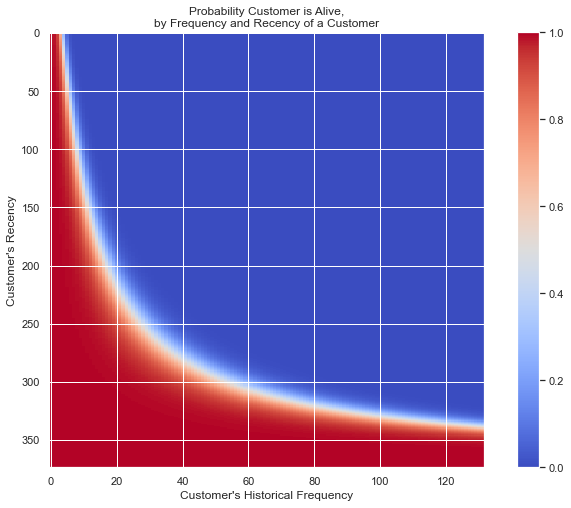

In [20]:
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8));
plot_probability_alive_matrix(bgf_modeli);

**gözlemler:**

* yakın zamanda alışveriş yapan müşteriler neredeyse kesinlikle "aktif".
* yakın zamanda değil, çok şey satın alan müşteriler muhtemelen pasifleşmiştir. ve geçmişte ne kadar çok şey satın alırlarsa, pasifleşme olasılıkları da o kadar yüksektir. sağ üstte temsil edilirler.

müşterileri “önümüzdeki dönemde beklenen en yüksek alışverişlerden” en düşük seviyeye doğru sıralayabiliriz. modelimiz, müşterilerin alışveriş geçmişlerini kullanarak, bir müşterinin gelecek dönemde beklenen alışverişlerini tahmin edecek bir yöntem de içerir:

In [21]:
t = 1
rfm_verisi['predicted_purchases'] = bgf_modeli.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                                   rfm_verisi['frequency'], 
                                                                                                   rfm_verisi['recency'], 
                                                                                                   rfm_verisi['T'])

rfm_verisi.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
Customer ID,,,,,
14606,88.0,372.0,373.0,134.975341,0.201005
15311,89.0,373.0,373.0,676.210899,0.203269
17841,111.0,372.0,373.0,360.246937,0.253053
12748,113.0,373.0,373.0,292.462301,0.257581
14911,131.0,372.0,373.0,1092.792290,0.298312


modelimiz ne kadar iyi uymuş?

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

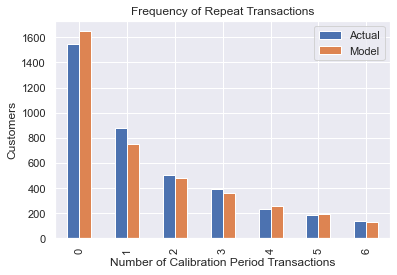

In [22]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf_modeli)

modelin kalibrasyon ve test dönemi için uygunluğunun testi:

In [23]:
from lifetimes.utils import calibration_and_holdout_data

test_verisi = calibration_and_holdout_data(
                                        veri_son_yıl, 
                                        'Customer ID', 
                                        'DailyDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-09' )

In [24]:
test_verisi.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346,0.0,0.0,141.0,0.0,184.0
12347,2.0,121.0,183.0,4.0,184.0
12348,2.0,110.0,174.0,1.0,184.0
12350,0.0,0.0,126.0,0.0,184.0
12352,3.0,34.0,112.0,3.0,184.0


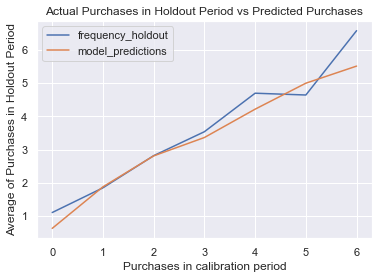

In [25]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.1)

bgf_test = bgf.fit(test_verisi['frequency_cal'], 
                   test_verisi['recency_cal'], 
                   test_verisi['T_cal'])

plot_calibration_purchases_vs_holdout_purchases(bgf_test, test_verisi);

bir müşterinin gelecek dayranışlarının tahmini:

In [26]:
t = 10

müşteri = rfm_verisi.loc[12348]

bgf_modeli.predict(t, 
                   müşteri['frequency'], 
                   müşteri['recency'], 
                   müşteri['T'])

0.0895593753940358

**gözlemler:**

* modelimiz, 12348 id'li müşterinin gelecek alışverişin 10 gün içinde 0,08 olasılıkla gerçekleşeceğini tahmin eder.

en iyi müşterimiz için aktif olma olasılığı:

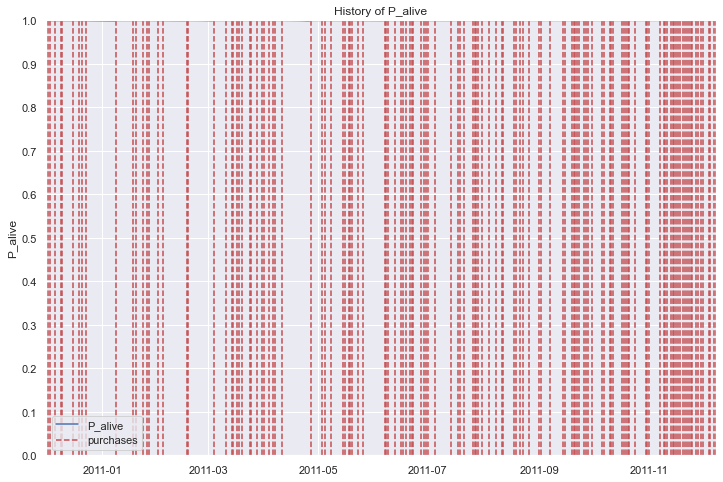

In [27]:
from lifetimes.plotting import plot_history_alive

müşteri_id = 14911
başlangıçtan_bu_yana_geçen_süre = 365
müşteri_verisi = veri_son_yıl.loc[veri_son_yıl['Customer ID'] == müşteri_id]

fig = plt.figure(figsize=(12,8));
plot_history_alive(bgf_modeli, 
                   başlangıçtan_bu_yana_geçen_süre, 
                   müşteri_verisi, 
                   'DailyDate');

**gözlemler:**

* en iyi müşterimiz kesinlikle aktif, ancak 2011'in başlarında birkaç kez pasifleşmiş.

son olarak parasal değeri de hesaba katarak müşteri yaşaboyu değerini hesaplayalım.

* Gamma-Gamma modeli ile bunu gerçekleştireceğiz. kaynak: http://www.brucehardie.com/notes/025/gamma_gamma.pdf
* bizden yalnızca en az bir kez tekrarlı alışveriş yapmış müşterileri tahmin edelim. 

In [28]:
geri_dönen_müşteriler = rfm_verisi[rfm_verisi['frequency']>0]

print(f"en az bir kez tekrarlı alışveriş yapan müşteri sayısı : {geri_dönen_müşteriler.shape[0]}")
geri_dönen_müşteriler.head()

en az bir kez tekrarlı alışveriş yapan müşteri sayısı : 2790


,frequency,recency,T,monetary_value,predicted_purchases
Customer ID,,,,,
12347,6.0,365.0,367.0,599.701667,0.015656
12348,3.0,283.0,358.0,301.480000,0.008956
12352,6.0,260.0,296.0,368.256667,0.018697
12356,2.0,303.0,325.0,269.905000,0.007172
12358,1.0,149.0,150.0,683.200000,0.008340


Gamma-Gamma modeli:

In [29]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.0)

ggf_modeli = ggf.fit(
    geri_dönen_müşteriler['frequency'],
    geri_dönen_müşteriler['monetary_value']
)

In [30]:
ggf_modeli.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,2.110995,0.112742,1.890021,2.331968
q,3.436208,0.138229,3.165280,3.707136
v,479.331655,42.101694,396.812335,561.850976


şimdi modeli uygulayarak, her bir müşterinin yaşamboyu değerini hesaplayabiliriz:

In [31]:
geri_dönen_müşteriler['customer_lifetime_value'] = ggf_modeli.conditional_expected_average_profit(
    geri_dönen_müşteriler['frequency'],
    geri_dönen_müşteriler['monetary_value']
)

In [32]:
geri_dönen_müşteriler.head()

,frequency,recency,T,monetary_value,predicted_purchases,customer_lifetime_value
Customer ID,,,,,,
12347,6.0,365.0,367.0,599.701667,0.015656,569.962142
12348,3.0,283.0,358.0,301.480000,0.008956,333.113304
12352,6.0,260.0,296.0,368.256667,0.018697,375.852702
12356,2.0,303.0,325.0,269.905000,0.007172,323.120874
12358,1.0,149.0,150.0,683.200000,0.008340,539.694007


en değerli müşteriler:

In [33]:
geri_dönen_müşteriler.sort_values(by='customer_lifetime_value').tail()

,frequency,recency,T,monetary_value,predicted_purchases,customer_lifetime_value
Customer ID,,,,,,
17450,26.0,359.0,367.0,7398.536538,0.061533,7101.748429
12415,15.0,313.0,337.0,7860.210000,0.038975,7328.343687
18102,25.0,367.0,367.0,9349.477200,0.059243,8955.255455
15749,1.0,97.0,332.0,21535.900000,0.004544,10220.357040
16446,1.0,205.0,205.0,168469.600000,0.006665,78432.897284
